In [141]:
path = '/home/parkej95/CSE283/AD_prediction_blood'

In [242]:
import importlib
import pandas as pd
from function_lib import load_data, _load_metadata, _load_rna_seq, normalize_RNAseq, Classifier, plot_AUC, plot_CM, apply_classifier
import function_lib

# Reload the module to reflect any changes
importlib.reload(function_lib)

<module 'function_lib' from '/home/parkej95/CSE283/AD_prediction_blood/function_lib.py'>

Epoch 20/300, Loss: 0.5514, F1 Score: 0.7433
Epoch 40/300, Loss: 0.5322, F1 Score: 0.7424
Epoch 60/300, Loss: 0.5229, F1 Score: 0.7594
Epoch 80/300, Loss: 0.5102, F1 Score: 0.7537
Epoch 100/300, Loss: 0.5080, F1 Score: 0.7547
Epoch 120/300, Loss: 0.4993, F1 Score: 0.7576
Epoch 140/300, Loss: 0.4966, F1 Score: 0.7594
Epoch 160/300, Loss: 0.4979, F1 Score: 0.7623
Epoch 180/300, Loss: 0.4948, F1 Score: 0.7623
Epoch 200/300, Loss: 0.4935, F1 Score: 0.7601
Epoch 220/300, Loss: 0.4926, F1 Score: 0.7612
Epoch 240/300, Loss: 0.4841, F1 Score: 0.7704
Epoch 260/300, Loss: 0.4843, F1 Score: 0.7675
Epoch 280/300, Loss: 0.4816, F1 Score: 0.7584
Epoch 300/300, Loss: 0.4816, F1 Score: 0.7778
Fold 1, Loss: 0.8230
Epoch 20/300, Loss: 0.5888, F1 Score: 0.6977
Epoch 40/300, Loss: 0.5584, F1 Score: 0.7239
Epoch 60/300, Loss: 0.5413, F1 Score: 0.7554
Epoch 80/300, Loss: 0.5328, F1 Score: 0.7633
Epoch 100/300, Loss: 0.5275, F1 Score: 0.7676
Epoch 120/300, Loss: 0.5287, F1 Score: 0.7719
Epoch 140/300, Loss: 

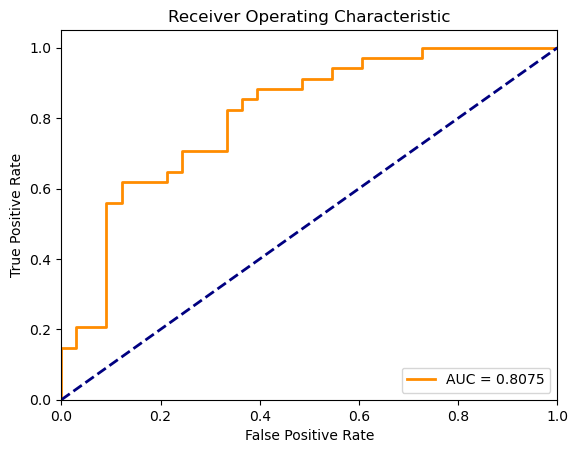

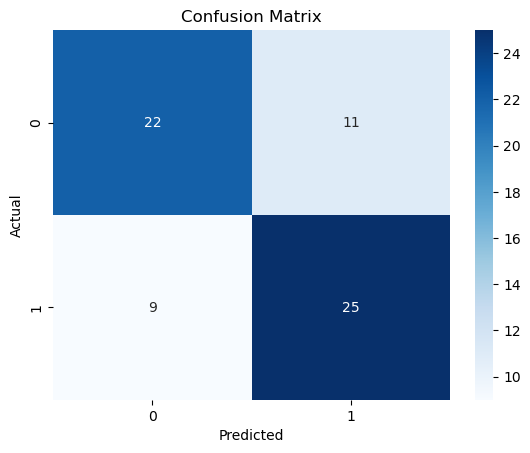

'/home/parkej95/CSE283/AD_prediction_blood/toden/toden_model.pkl'

In [243]:
#Training with Toden Data
input_meta = '/home/parkej95/CSE283/AD_prediction_blood/toden/toden_metadata.xlsx'
input_seq = '/home/parkej95/CSE283/AD_prediction_blood/toden/toden_counts.txt'
model_path = '/home/parkej95/CSE283/AD_prediction_blood/toden/toden_model.pkl'
id_col = 'Run'
label_col = 'Disease'
pca_n = 5

updown_genes = pd.read_csv('/home/parkej95/CSE283/AD_prediction_blood/toden/toden_counts_updown_genes.csv')
updown_genes = updown_genes['index']

# Load the data
train_data, pca_model = load_data(input_meta, input_seq, id_col, label_col, run_pca = True, pca_n = pca_n, gene_list = updown_genes)
Classifier(data = train_data, best_model_path=model_path, num_features =pca_n, epochs=300)


F1 Score: 0.7514


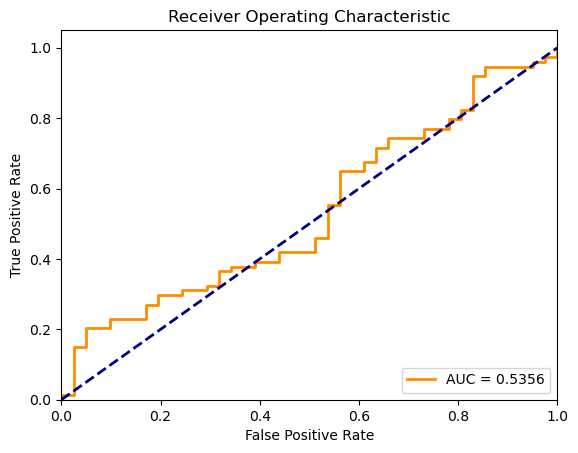

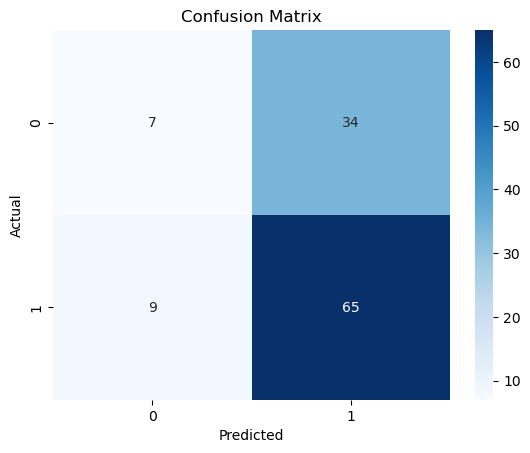

0.7514450867052023

In [244]:
#Testing with silver_seq data
input_meta = '/home/parkej95/CSE283/AD_prediction_blood/silver_seq/silver_seq_metadata.xlsx'
input_seq = '/home/parkej95/CSE283/AD_prediction_blood/silver_seq/silver_seq_counts.txt'
id_col = 'sample_id_alias'
label_col = 'donor_group'

data, _ = load_data(input_meta, input_seq, id_col, label_col, run_pca = False, pca_n = pca_n, pca_model = pca_model, gene_list = updown_genes)
apply_classifier(data, model_path, num_features=pca_n)

F1 Score: 0.6564


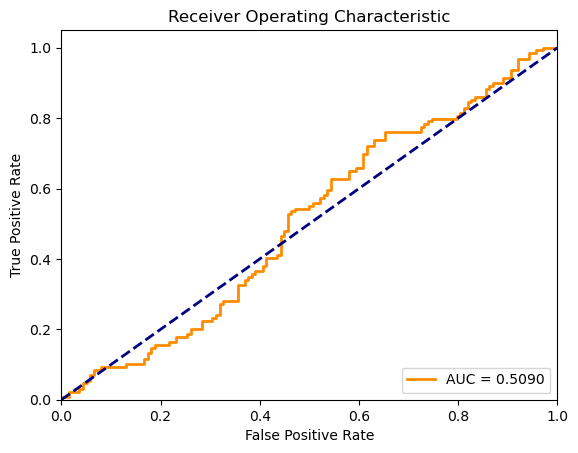

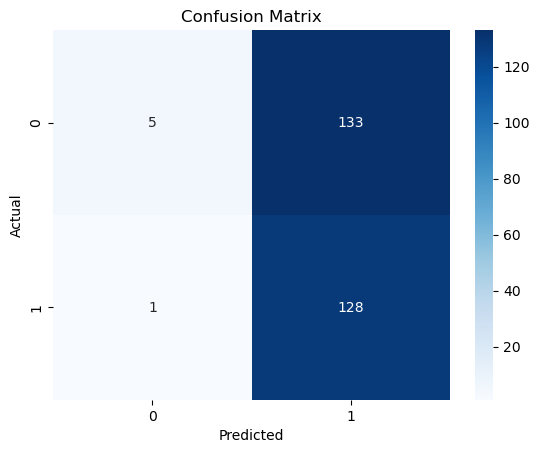

0.6564102564102564

In [245]:
#Testing with burgos data
input_meta = '/home/parkej95/CSE283/AD_prediction_blood/burgos_dbgap/burgos_dbgap_metadata.xlsx'
input_seq = '/home/parkej95/CSE283/AD_prediction_blood/burgos_dbgap/burgos_dbgap_counts.txt'
id_col = 'biospecimen_repository_sample_id'
label_col = 'AD'

data, _ = load_data(input_meta, input_seq, id_col, label_col, run_pca = False, pca_n = pca_n, pca_model = pca_model, gene_list = updown_genes)
apply_classifier(data, model_path, num_features=pca_n)

Epoch 20/300, Loss: 0.6920, F1 Score: 0.5882
Epoch 40/300, Loss: 0.6873, F1 Score: 0.2636
Epoch 60/300, Loss: 0.6842, F1 Score: 0.3514
Epoch 80/300, Loss: 0.6664, F1 Score: 0.5397
Epoch 100/300, Loss: 0.6416, F1 Score: 0.5543
Epoch 120/300, Loss: 0.6459, F1 Score: 0.5579
Epoch 140/300, Loss: 0.6321, F1 Score: 0.5444
Epoch 160/300, Loss: 0.6351, F1 Score: 0.5667
Epoch 180/300, Loss: 0.6307, F1 Score: 0.5587
Epoch 200/300, Loss: 0.6277, F1 Score: 0.5556
Epoch 220/300, Loss: 0.6299, F1 Score: 0.5525
Epoch 240/300, Loss: 0.6315, F1 Score: 0.5475
Epoch 260/300, Loss: 0.6265, F1 Score: 0.5495
Epoch 280/300, Loss: 0.6218, F1 Score: 0.5525
Epoch 300/300, Loss: 0.6251, F1 Score: 0.5525
Fold 1, Loss: 2.5118
Epoch 20/300, Loss: 0.6901, F1 Score: 0.3727
Epoch 40/300, Loss: 0.6865, F1 Score: 0.4142
Epoch 60/300, Loss: 0.6815, F1 Score: 0.4483
Epoch 80/300, Loss: 0.6802, F1 Score: 0.4457
Epoch 100/300, Loss: 0.6827, F1 Score: 0.4607
Epoch 120/300, Loss: 0.6792, F1 Score: 0.4778
Epoch 140/300, Loss: 

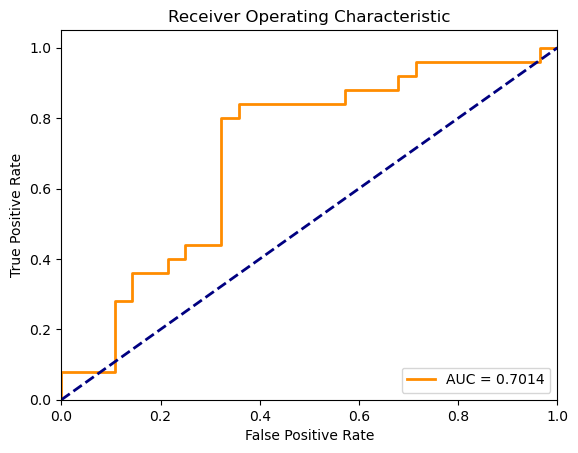

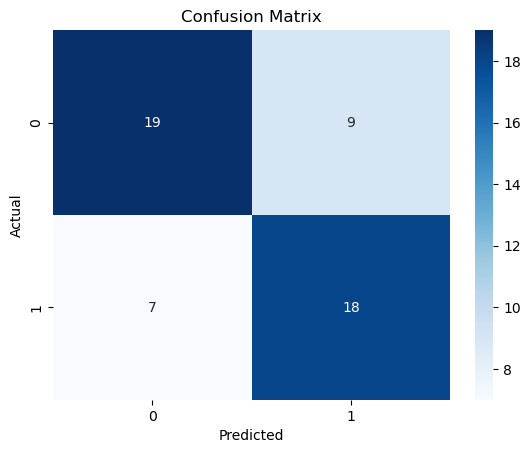

'/home/parkej95/CSE283/AD_prediction_blood/burgos_dbgap/burgos_dbgap_model.pkl'

In [247]:
# Train on Burgos data
input_meta = '/home/parkej95/CSE283/AD_prediction_blood/burgos_dbgap/burgos_dbgap_metadata.xlsx'
input_seq = '/home/parkej95/CSE283/AD_prediction_blood/burgos_dbgap/burgos_dbgap_counts.txt'
model_path = '/home/parkej95/CSE283/AD_prediction_blood/burgos_dbgap/burgos_dbgap_model.pkl'
id_col = 'biospecimen_repository_sample_id'
label_col = 'AD'
pan_n = 10

train_data, pca_model = load_data(input_meta, input_seq, id_col, label_col, run_pca = True, pca_n = pca_n, gene_list = updown_genes)
Classifier(data = train_data, best_model_path=model_path, num_features = pca_n, epochs=300)



F1 Score: 0.7232


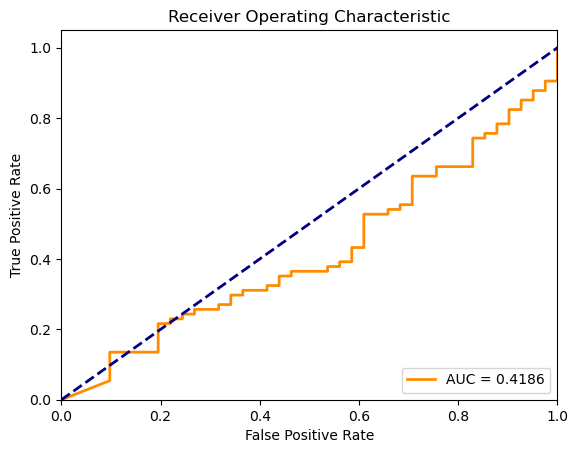

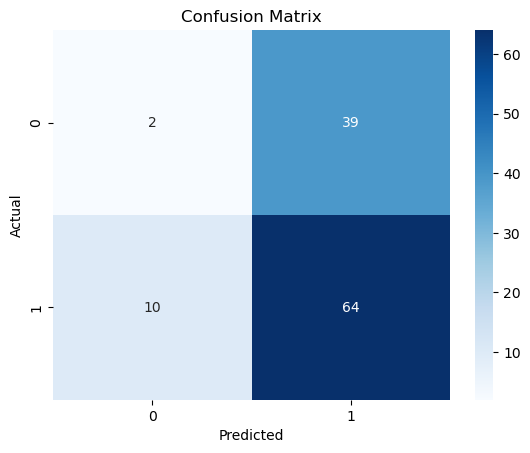

0.7231638418079096

In [248]:
#Testing with silver_seq data
input_meta = '/home/parkej95/CSE283/AD_prediction_blood/silver_seq/silver_seq_metadata.xlsx'
input_seq = '/home/parkej95/CSE283/AD_prediction_blood/silver_seq/silver_seq_counts.txt'
id_col = 'sample_id_alias'
label_col = 'donor_group'

data, _ = load_data(input_meta, input_seq, id_col, label_col, run_pca = False, pca_n = pca_n, pca_model = pca_model, gene_list = updown_genes)
apply_classifier(data, model_path, num_features=pca_n)



F1 Score: 0.6722


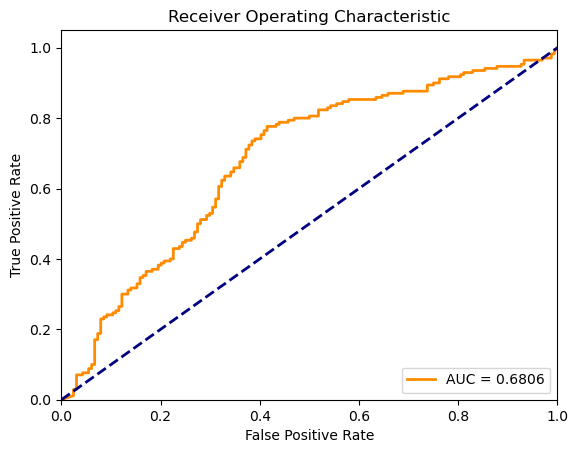

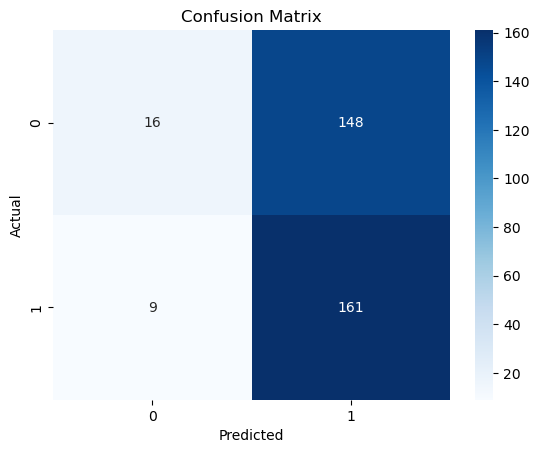

0.6722338204592901

In [250]:
#Testing with toden data

input_meta = '/home/parkej95/CSE283/AD_prediction_blood/toden/toden_metadata.xlsx'
input_seq = '/home/parkej95/CSE283/AD_prediction_blood/toden/toden_counts.txt'
id_col = 'Run'
label_col = 'Disease'

data, _ = load_data(input_meta, input_seq, id_col, label_col, run_pca = False, pca_n = pca_n, pca_model = pca_model, gene_list = updown_genes)
apply_classifier(data, model_path, num_features=pca_n)
